# ClimateLearn Quickstart

This notebook shows how to develop a weather forecasting model with deep learning in ClimateLearn from end-to-end. First, we install the library from the GitHub repository.

Mount the Google Drive file system, then import ClimateLearn and related libraries.

In [1]:
import sys
sys.path.append('/app')

from src.climate_learn import LitModule
from src.climate_learn import download_weatherbench
from src.climate_learn import convert_nc2npz
from src.climate_learn import IterDataModule
from src.climate_learn.utils import visualize_at_index, visualize_mean_bias
from src.climate_learn import load_downscaling_module
from src.climate_learn.data.processing.era5_constants import (
    DEFAULT_PRESSURE_LEVELS, PRESSURE_LEVEL_VARS)
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar,
)
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torch

In [2]:
from src.climate_learn.transforms import Mask, Denormalize

The downloaded and processed data is loaded into a PyTorch Lightning data module. In the following code cell, we use the following settings:
- `subsample = 6`. The dataset is subsampled at 6 hour intervals; this is done so that training is faster, but one could also use no subsampling (_i.e._, `subsample = 1`, which is the default).
- `pred_range = 24`. The model's objective is to predict `2m_temperature` 24 hours in the future.
- `history = 3`. When making a prediction, the model is given data at time `t`, `t-subsample`, and `t-subsample*2`.
- `task = "direct-forecasting"`. Given the inputs, the model directly predicts the outputs at `pred_range`. Other methods of forecasting are iterative forecasting and continuous forecasting. We refer to section 3 of [this paper by Rasp and Theurey](https://arxiv.org/pdf/2008.08626.pdf) for a description of these forecasting types.

Note further that `in_vars` and `out_vars` are the same, meaning the model consumes historical temperature and geopotential as input and produces predicted temperature and geopotential as output.

Before running this next code cell, we recommend switching to a GPU-accelerated runtime then re-running all code cells related to installation and library imports. You do _NOT_ need to re-download/process the data. Those should be saved to your Google Drive.

In [5]:
dm = IterDataModule(
    task="downscaling",
    inp_root_dir="/app/data/processed/cmip6-cmip6/LR",
    out_root_dir="/app/data/processed/cmip6-cmip6/HR",
    in_vars = ["air_temperature", "u_component_of_wind", "v_component_of_wind", "precipitation"],
    out_vars = ["air_temperature", "u_component_of_wind", "v_component_of_wind", "precipitation"],
    subsample=1,
    batch_size=512,
    num_workers=4,
)
dm.setup()

In [7]:
# Retrieve the shape of the 2m temperature data from the first item in the test dataset
temperature_shape = next(iter(dm.data_test.dataset.dataset))[0]["air_temperature"].shape
print(f"Shape of temperature data: {temperature_shape}")

# Get the shape of the first batch of data from the test dataloader
first_batch_shape = next(iter(dm.test_dataloader()))[0].shape
print(f"Shape of the first batch from test dataloader: {first_batch_shape}")

in_vars, out_vars = dm.get_data_variables()
in_shape, out_shape = dm.get_data_dims()
in_channels, in_height, in_width = in_shape[1:]
out_channels, out_height, out_width = out_shape[1:]

# Printing detailed information about input and output shapes for clarity
print(
    f"Input Channels = {in_channels}, Input Height = {in_height}, Input Width = {in_width}"
)
print(
    f"Output Channels = {out_channels}, Output Height = {out_height}, Output Width = {out_width}"
)

Shape of temperature data: (73, 96, 192)
Shape of the first batch from test dataloader: torch.Size([146, 4, 96, 192])
Input Channels = 4, Input Height = 96, Input Width = 192
Output Channels = 4, Output Height = 192, Output Width = 384


Run baseline methods, climatology and persistence. Climatology uses the average value observed in the training data as its predictions. Persistence uses the last observed value as its predictio. For our setup, that would mean using the values of `2m_temperature` and `toa_incident_solar_radiation` at time `t` as the predictions for time `t+24`.

In [9]:
bicubic = load_downscaling_module(
                                data_module=dm,
                                architecture="bicubic-interpolation",
                                )

bilinear = load_downscaling_module(
                                data_module=dm,
                                architecture="bilinear-interpolation",
)

nearest = load_downscaling_module(
                                data_module=dm,
                                architecture="nearest-interpolation",
)

trainer = pl.Trainer(accelerator="cpu")

trainer.validate(bilinear, dm)
# trainer.validate(nearest, dm)
# trainer.validate(bicubic, dm)

trainer.test(bilinear, dm)
# trainer.test(nearest, dm)
# trainer.test(bicubic, dm)

GPU available: True (cuda), used: False


Loading architecture: bicubic-interpolation
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: mse
No train transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading validation loss: mse
Loading validation transform: denormalize
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: rmse
Loading test loss: pearson
Loading test loss: mean_bias
Loading test transform: denormalize
Loading test transform: denormalize
Loading test transform: denormalize
Loading architecture: bilinear-interpolation
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: mse
No train transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading validation loss: mse
Loading validation 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/bias_correction/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      val/mean_bias:aggregate      │        0.07395106554031372        │
│   val/mean_bias:air_temperature   │        0.18015289306640625        │
│    val/mean_bias:precipitation    │       0.020407676696777344        │
│ val/mean_bias:u_component_of_wind │        0.07797238230705261        │
│ val/mean_bias:v_component_of_wind │       0.017271341755986214        │
│         val/mse:aggregate         │        0.9971306920051575         │
│      val/mse:air_temperature      │        0.04422309249639511        │
│       val/mse:precipitation       │        1.4488933086395264         │
│    val/mse:u_component_of_wind    │        1.0315771102905273         │
│    val/mse:v_component_of_wind    │        1.4638293981552124         │
│       val/pearson:aggregate       │        0.49231427907943726        │
│    val/pearson:air_temperature    │        0.9785582423210144         │
│     val/pearson:precipitation     │        0.2578556537628174         │
│  val/pearson:u_component_of_wind  │        0.4858897030353546         │
│  val/pearson:v_component_of_wind  │        0.24695348739624023        │
│        val/rmse:aggregate         │         5.398252487182617         │
│     val/rmse:air_temperature      │        4.4555206298828125         │
│      val/rmse:precipitation       │         6.54288387298584          │
│   val/rmse:u_component_of_wind    │         5.311598777770996         │
│   val/rmse:v_component_of_wind    │         5.283006191253662         │
└───────────────────────────────────┴───────────────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric             ┃            DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/mean_bias:aggregate      │        0.10918299108743668         │
│   test/mean_bias:air_temperature   │         0.4095916748046875         │
│    test/mean_bias:precipitation    │        0.005211532115936279        │
│ test/mean_bias:u_component_of_wind │        0.02943168580532074         │
│ test/mean_bias:v_component_of_wind │       -0.007502904627472162        │
│       test/pearson:aggregate       │         0.471500962972641          │
│    test/pearson:air_temperature    │         0.9770058393478394         │
│     test/pearson:precipitation     │        0.24264484643936157         │
│  test/pearson:u_component_of_wind  │         0.4464988112449646         │
│  test/pearson:v_component_of_wind  │        0.21985435485839844         │
│        test/rmse:aggregate         │         5.496241092681885          │
│     test/rmse:air_temperature      │         4.585342884063721          │
│      test/rmse:precipitation       │         6.583727836608887          │
│   test/rmse:u_component_of_wind    │         5.436487674713135          │
│   test/rmse:v_component_of_wind    │         5.3794050216674805         │
└────────────────────────────────────┴────────────────────────────────────┘

[{'test/rmse:air_temperature': 4.585342884063721,
  'test/rmse:u_component_of_wind': 5.436487674713135,
  'test/rmse:v_component_of_wind': 5.3794050216674805,
  'test/rmse:precipitation': 6.583727836608887,
  'test/rmse:aggregate': 5.496241092681885,
  'test/pearson:air_temperature': 0.9770058393478394,
  'test/pearson:u_component_of_wind': 0.4464988112449646,
  'test/pearson:v_component_of_wind': 0.21985435485839844,
  'test/pearson:precipitation': 0.24264484643936157,
  'test/pearson:aggregate': 0.471500962972641,
  'test/mean_bias:air_temperature': 0.4095916748046875,
  'test/mean_bias:u_component_of_wind': 0.02943168580532074,
  'test/mean_bias:v_component_of_wind': -0.007502904627472162,
  'test/mean_bias:precipitation': 0.005211532115936279,
  'test/mean_bias:aggregate': 0.10918299108743668}]

ClimateLearn provides standard metrics. For forecasting, it displays the latitude weighted RMSE and the latitude weighted ACC. Lower RMSE is better, while higher ACC is better. ACC has a range of [0, 1]. We use latitude weighting to adjust for the fact that we flatten the curved surface of the Earth to a 2D grid, which is squishes information at the equator and stretches information near the poles. For more info about these metrics, see this link: https://geo.libretexts.org/Bookshelves/Meteorology_and_Climate_Science/Practical_Meteorology_(Stull)/20%3A_Numerical_Weather_Prediction_(NWP)/20.7%3A_Forecast_Quality_and_Verfication

Also, you might have noticed the metrics with `aggregate` as the suffix. These represent averages. For example, `lat_rmse:aggregate` is the average of `lat_rmse:temperature` and `lat_rmse:geopotential`.

Besides these metrics, ClimateLearn also provides visualization tools. In the following cell, we first get the denormalization tranfsorm to transform the data returned by the PyTorch Lightning data module, which was normalized to $\mathcal{N}(0,1)$, back into its original range. As we can see the logging messages displayed in the previous cell's output, the persistence model's 0-th test tranfsormation is denormalization.

Then, we visualize the ground truth, prediction, and bias for the persistence prediction made on the 0-th sample of the testing set. Bias is defined as predicted minus observed (see the link provided above). It is useful to gain a visual understanding of model performance. In this example, we can see that persistence generally underpredicts the true values.

For weather forecasting with history greater than 1, the visualization function also returns a value which we save here as `in_graphic`. This graphic can be animated, as seen in the next code cell.

0it [00:01, ?it/s]


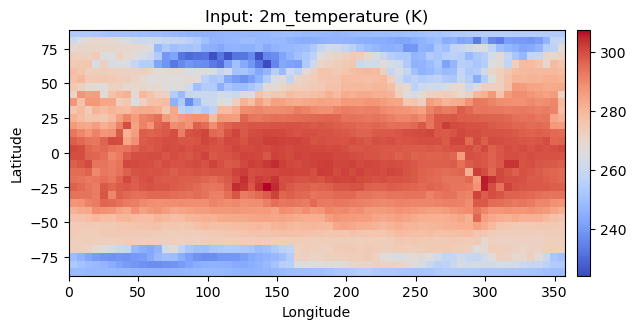

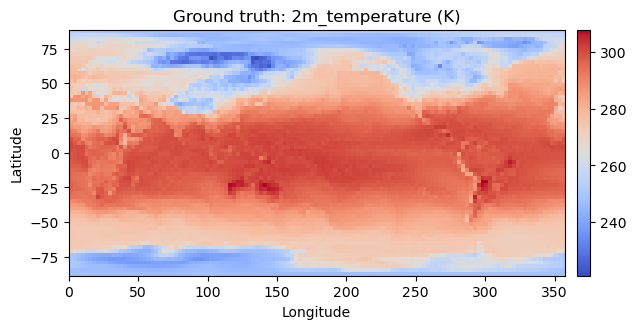

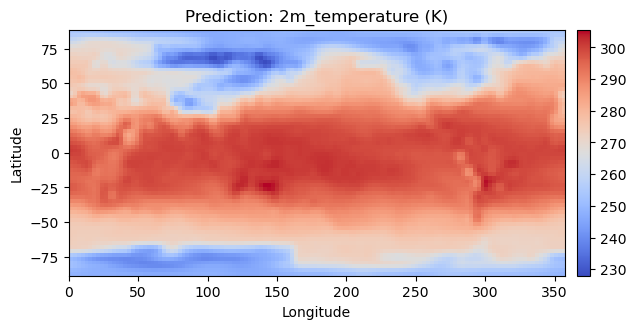

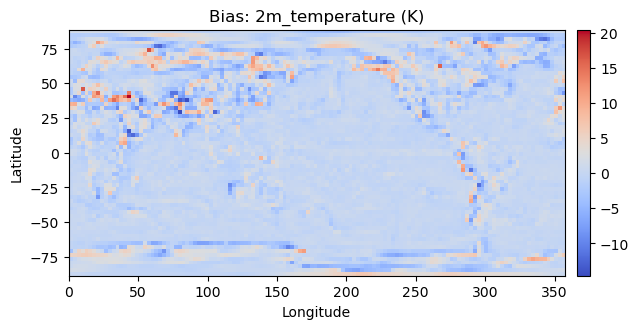

In [9]:
denorm = bilinear.test_target_transforms[0]
in_graphic = visualize_at_index(
    bilinear,
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)

0it [00:00, ?it/s]


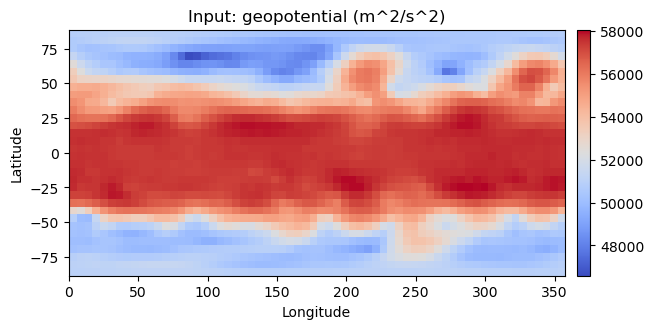

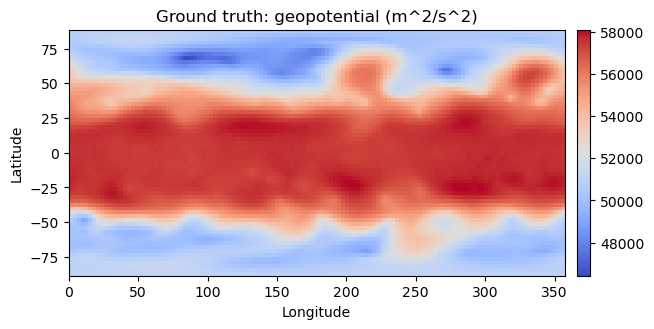

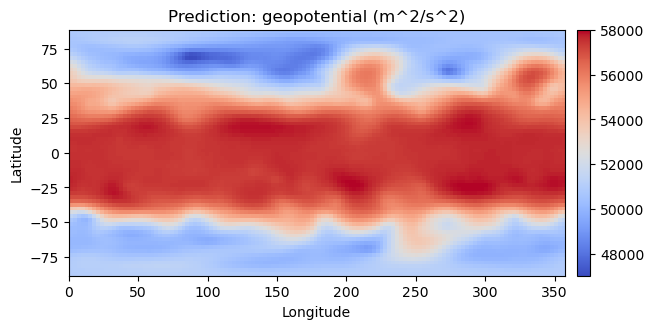

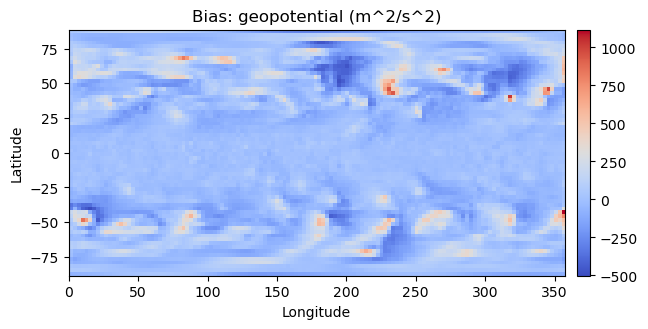

In [8]:
in_graphic = visualize_at_index(
    bilinear,
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="geopotential_500",
    src="era5",
    index=0,
)

0it [00:00, ?it/s]


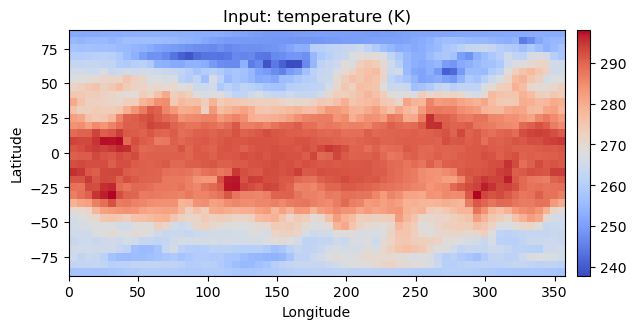

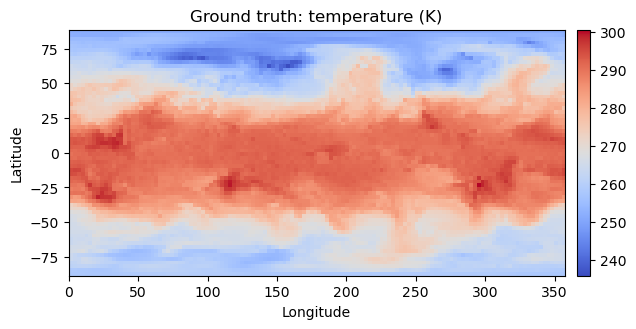

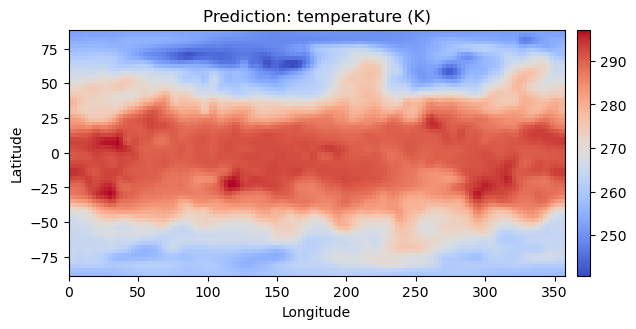

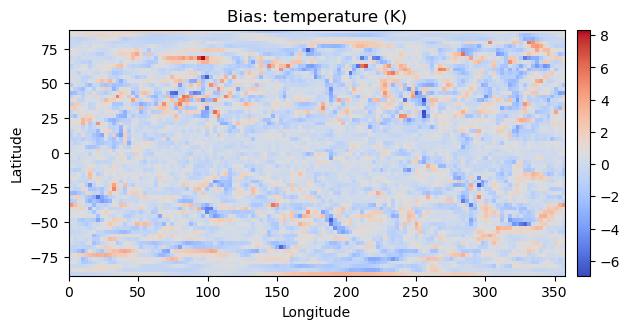

In [10]:
in_graphic = visualize_at_index(
    bilinear,
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="temperature_850",
    src="era5",
    index=0,
)

Moreover, ClimateLearn can display the mean bias, which is the average bias at each coordinate across the entire testing set.

20it [00:02,  9.69it/s]


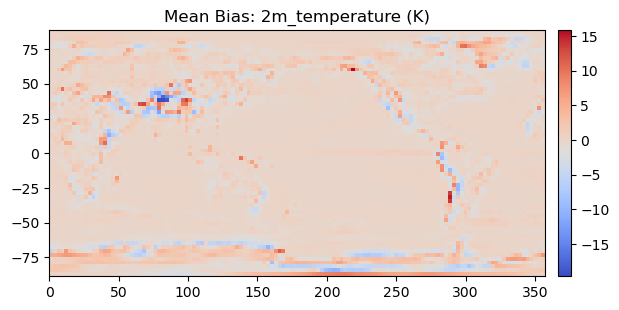

In [11]:
visualize_mean_bias(
    dm, bilinear, out_transform=denorm, variable="2m_temperature", src="era5"
)

20it [00:01, 11.52it/s]


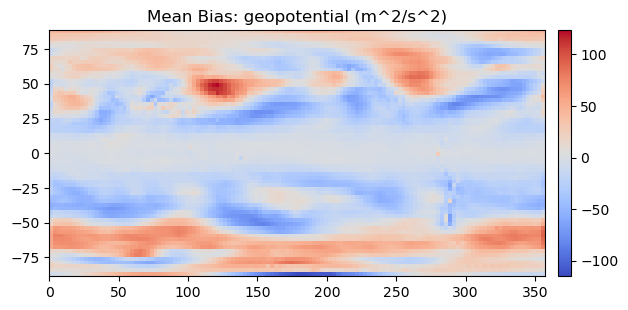

In [12]:
visualize_mean_bias(
    dm, bilinear, out_transform=denorm, variable="geopotential_500", src="era5"
)

Next, we can check deep learning models complexity 

In [4]:
# Set up data
variables = [
    "land_sea_mask",
    "orography",
    "lattitude",
    "toa_incident_solar_radiation",
    "2m_temperature",
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "geopotential",
    "temperature",
    "relative_humidity",
    "specific_humidity",
    "u_component_of_wind",
    "v_component_of_wind",
]
in_vars = []
for var in variables:
    if var in PRESSURE_LEVEL_VARS:
        for level in DEFAULT_PRESSURE_LEVELS:
            in_vars.append(var + "_" + str(level))
    else:
        in_vars.append(var)

In [5]:
dm = IterDataModule(
    task="downscaling",
    inp_root_dir="/app/data/ClimateLearn/processed/weatherbench/era5/5.625deg",
    out_root_dir="/app/data/ClimateLearn/processed/weatherbench/era5/2.8125deg",
    in_vars=in_vars,
    out_vars=["2m_temperature", "temperature_850", "geopotential_500"],
    subsample=1,
    batch_size=512,
    num_workers=4,
)
dm.setup()

In [6]:
# Retrieve the shape of the 2m temperature data from the first item in the test dataset
temperature_shape = next(iter(dm.data_test.dataset.dataset))[0]["2m_temperature"].shape
print(f"Shape of 2m temperature data: {temperature_shape}")

# Get the shape of the first batch of data from the test dataloader
first_batch_shape = next(iter(dm.test_dataloader()))[0].shape
print(f"Shape of the first batch from test dataloader: {first_batch_shape}")

in_vars, out_vars = dm.get_data_variables()
in_shape, out_shape = dm.get_data_dims()
in_channels, in_height, in_width = in_shape[1:]
out_channels, out_height, out_width = out_shape[1:]

# Printing detailed information about input and output shapes for clarity
print(
    f"Input Channels = {in_channels}, Input Height = {in_height}, Input Width = {in_width}"
)
print(
    f"Output Channels = {out_channels}, Output Height = {out_height}, Output Width = {out_width}"
)

Shape of 2m temperature data: (546, 32, 64)
Shape of the first batch from test dataloader: torch.Size([512, 49, 32, 64])
Input Channels = 49, Input Height = 32, Input Width = 64
Output Channels = 3, Output Height = 64, Output Width = 128


In [ ]:
vit = load_downscaling_module(data_module=dm, architecture="vit")
unet = load_downscaling_module(data_module=dm, architecture="unet")
resnet = load_downscaling_module(data_module=dm, architecture="resnet")
samvit = load_downscaling_module(data_module=dm, architecture="samvit")
ynet = load_downscaling_module(data_module=dm, architecture="ynet", upsampling=None)
deepsd = load_downscaling_module(data_module=dm, architecture="deepsd", upsampling=None)
diffusion = load_downscaling_module(data_module=dm, architecture="diffusion", upsampling=None)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
resnet_params = count_parameters(resnet)
unet_params = count_parameters(unet)
vit_params = count_parameters(vit)
samvit_params = count_parameters(samvit)
ynet_params = count_parameters(ynet)
deepsd_params = count_parameters(deepsd)
diffusion_params = count_parameters(diffusion)
print(f"# of Resnet params: {resnet_params/1e6:.2f}M")
print(f"# of Unet params: {unet_params/1e6:.2f}M")
print(f"# of ViT params: {vit_params/1e6:.2f}M")
print(f"# of Samvit params: {samvit_params/1e6:.2f}M")
print(f"# of Ynet params: {ynet_params/1e6:.2f}M")
print(f"# of DeepSD params: {deepsd_params/1e6:.2f}M")
print(f"# of Diffusion params: {diffusion_params/1e6:.2f}M")

# of Resnet params: 8.61M
# of Unet params: 11.99M
# of ViT params: 1.91M
# of Samvit params: 1.10M
# of Ynet params: 1.75M
# of DeepSD params: 0.31M
# of Diffusion params: 10.69M


In [ ]:
from torch_operation_counter import OperationsCounterMode
from thop import profile
import torch.nn as nn

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

vit = vit.to(device)
resnet = resnet.to(device)
unet = unet.to(device)
samvit = samvit.to(device)
ynet = ynet.to(device)
diffusion = diffusion.to(device)
deepsd = deepsd.to(device)

# Dummy input tensor
x = torch.randn(1, in_channels, in_height, in_width).to(device)
results = []

for model, model_name in zip([vit, samvit, resnet, unet, ynet, diffusion, deepsd], ["vit", "samvit", "resnet", "unet", "ynet", "diffusion", "deepsd"]): 
    with OperationsCounterMode(model) as ops_counter:
        model(x)
    total_ops = ops_counter.total_operations / 1e9  # Convert to GigaOPs
    flops, params = profile(model, inputs=(x, ))  # Calculate FLOPs and parameters
    results.append([model_name, total_ops, flops / 1e9, params / 1e6])  # Append results

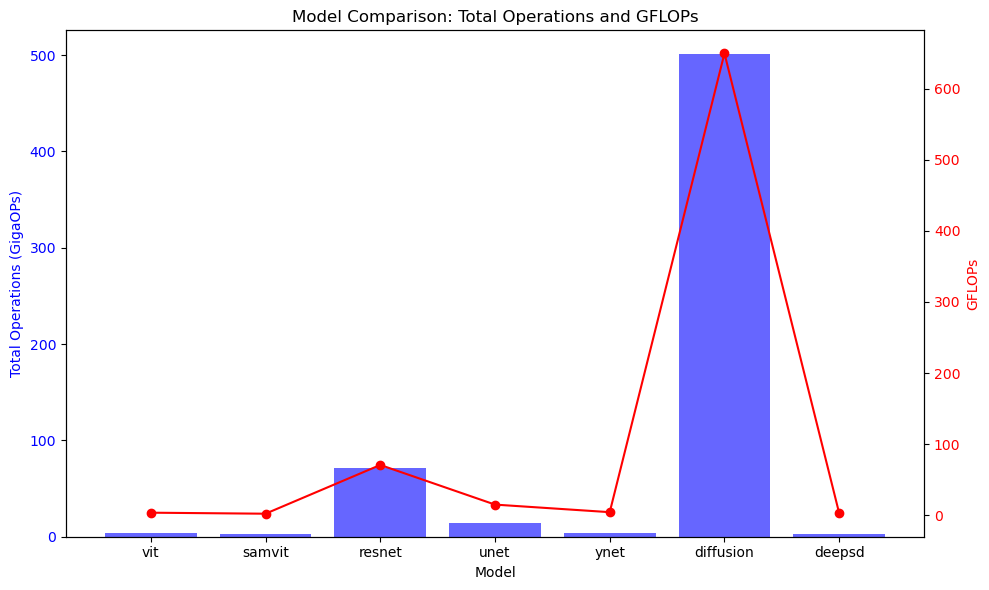

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
# Create DataFrame
df_results = pd.DataFrame(results, columns=["Model", "Total Operations (GigaOPs)", "GFLOPs", "Params (Millions)"])

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total operations and GFLOPs
ax1.bar(df_results["Model"], df_results["Total Operations (GigaOPs)"], color='b', alpha=0.6, label='Total Operations (GigaOPs)')
ax1.set_xlabel('Model')
ax1.set_ylabel('Total Operations (GigaOPs)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create another y-axis for GFLOPs
ax2 = ax1.twinx()
ax2.plot(df_results["Model"], df_results["GFLOPs"], color='r', marker='o', label='GFLOPs')
ax2.set_ylabel('GFLOPs', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and show plot
plt.title('Model Comparison: Total Operations and GFLOPs')
fig.tight_layout()

# Display the plot
plt.show()

In [17]:
df_results

,Model,Total Operations (GigaOPs),GFLOPs,Params (Millions)
0,vit,3.350987,3.360686,1.646220
1,samvit,2.582271,1.940914,0.836364
2,resnet,70.830565,70.556582,8.605571
3,unet,14.151723,14.763426,11.990339
4,ynet,4.082782,4.101466,1.746792
5,diffusion,500.647804,649.982378,10.685318
6,deepsd,2.564030,2.566873,0.312899
